# AIPI 590 - XAI | Adversarial Patches

Description: Here I create an adversarial patch from the 'Llama'class from Imagenet. The core idea is to create and test this patch to deceive machine learning models to assume test  images containing the patch are Llamas.

Christian Moreira

[![GitHub Repo](https://img.shields.io/badge/GitHub-Repo-black.svg?logo=github&style=for-the-badge)](https://github.com/U1186204/Adversarial-Patches/tree/main)

[![Open In Colab](https://img.shields.io/badge/Open%20In-Colab-F9AB00.svg?logo=googlecolab&style=for-the-badge)](https://colab.research.google.com/github/U1186204/Adversarial-Patches/blob/main/main.ipynb)



### Importing Libraries

In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torchvision.transforms.functional as TF

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch_lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

DATASET_PATH = "data"
CHECKPOINT_PATH = "saved_models/tutorial10"
CUSTOM_PATCH_PATH = os.path.join(CHECKPOINT_PATH, "custom")
os.makedirs(CUSTOM_PATCH_PATH, exist_ok=True)

pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)
print(f"Custom patch will be saved to: {CUSTOM_PATCH_PATH}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0
Custom patch will be saved to: saved_models/tutorial10/custom


In [2]:
import urllib.request
from urllib.error import HTTPError
import zipfile

base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Corrected unzipping line
                zip_ref.extractall(dir_name)

In [3]:
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [4]:
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)])

imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Did you run Cell 2? Is 'TinyImageNet' in your 'data' folder?"
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)

data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=0)

with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [5]:
target_class_name = 'llama'
target_class_idx = 355

assert target_class_name in label_names,

print(f"Target Acquired! We will make the model see: **{target_class_name}** (Index: {target_class_idx})")

PATCH_SIZE = 64

Target Acquired! We will make the model see: **llama** (Index: 355)


In [6]:

def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

exmp_batch, label_batch = next(iter(data_loader))

In [7]:
TENSOR_MEANS = torch.FloatTensor(NORM_MEAN).to(device)[:,None,None]
TENSOR_STD = torch.FloatTensor(NORM_STD).to(device)[:,None,None]

def patch_forward(patch):
    patch_0_1 = (torch.tanh(patch) + 1) / 2
    return (patch_0_1 - TENSOR_MEANS) / TENSOR_STD

def place_patch(img, patch):
    patch_img = patch_forward(patch)

    patch_height = patch.shape[1]
    patch_width = patch.shape[2]

    for i in range(img.shape[0]):
        mask = torch.ones_like(patch_img)

        angle = float(torch.empty(1).uniform_(-45, 45))
        patch_rotated = TF.rotate(patch_img, angle, fill=0)
        mask_rotated = TF.rotate(mask, angle, fill=0)

        scale_factor = float(torch.empty(1).uniform_(0.70, 1.1))
        new_height = int(patch_height * scale_factor)
        new_width = int(patch_width * scale_factor)

        if new_height < 1: new_height = 1
        if new_width < 1: new_width = 1

        patch_transformed = TF.resize(patch_rotated, [new_height, new_width], antialias=True)
        mask_transformed = TF.resize(mask_rotated, [new_height, new_width], antialias=True)
        mask_transformed = (mask_transformed > 0.5).float()

        if new_height >= img.shape[2]: h_offset = 0
        else: h_offset = np.random.randint(0, img.shape[2] - new_height - 1)

        if new_width >= img.shape[3]: w_offset = 0
        else: w_offset = np.random.randint(0, img.shape[3] - new_width - 1)

        target_area = img[i, :, h_offset : h_offset + new_height, w_offset : w_offset + new_width]

        img[i, :, h_offset : h_offset + new_height, w_offset : w_offset + new_width] = \
            (1.0 - mask_transformed) * target_area + mask_transformed * patch_transformed

    return img

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            for _ in range(4):
                img_labels = img_labels.to(device)
                img_device = img.clone().to(device)
                patch_img = place_patch(img_device, patch)

                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()

    if counter.item() == 0:
        return torch.tensor(0.0), torch.tensor(0.0)

    acc = tp.float() / counter
    top5 = tp_5.float() / counter
    return acc, top5

In [8]:


def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=0)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=0)

    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)

    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1], device=device), requires_grad=True)

    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    loss_module = nn.CrossEntropyLoss()

    print(f"Starting attack. Tuning patch to target class '{label_names[target_class]}'")

    for epoch in range(num_epochs):
        train_loss_sum = 0.0

        # ---!!! REMOVED TQDM WRAPPER ---!!!
        for img, _ in train_loader:
            # Bug fix: Move image to device FIRST
            img = img.to(device)
            img = place_patch(img, patch) # Now patching happens on GPU

            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            train_loss_sum += loss.item()

        avg_train_loss = train_loss_sum / len(train_loader)

        scheduler.step(avg_train_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1} finished. Avg Loss: {avg_train_loss:4.2f}, Current LR: {current_lr}")

    print("Training finished. Running final validation...")
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [9]:

EPOCHS_TO_TRAIN = 15

patch_tensor, val_results = patch_attack(
    pretrained_model,
    target_class=target_class_idx,
    patch_size=PATCH_SIZE,
    num_epochs=EPOCHS_TO_TRAIN
)

print("\n---!!! TRAINING COMPLETE !!!---")
print(f"Validation results for '{target_class_name}':")
print(f"  Top-1 Fooling Accuracy: {val_results['acc']*100.0:4.2f}%")
print(f"  Top-5 Fooling Accuracy: {val_results['top5']*100.0:4.2f}%")

# Save the patch tensor
patch_filename = os.path.join(CUSTOM_PATCH_PATH, f"{target_class_name}_patch.pt")
torch.save(patch_tensor, patch_filename)
print(f"Patch tensor saved to {patch_filename}")

Starting attack. Tuning patch to target class 'llama'
Epoch 1 finished. Avg Loss: 11.68, Current LR: 0.1
Epoch 2 finished. Avg Loss: 6.70, Current LR: 0.1
Epoch 3 finished. Avg Loss: 5.59, Current LR: 0.1
Epoch 4 finished. Avg Loss: 5.09, Current LR: 0.1
Epoch 5 finished. Avg Loss: 4.76, Current LR: 0.1
Epoch 6 finished. Avg Loss: 4.52, Current LR: 0.1
Epoch 7 finished. Avg Loss: 4.27, Current LR: 0.1
Epoch 8 finished. Avg Loss: 4.20, Current LR: 0.1
Epoch 9 finished. Avg Loss: 4.09, Current LR: 0.1
Epoch 10 finished. Avg Loss: 3.91, Current LR: 0.1
Epoch 11 finished. Avg Loss: 3.80, Current LR: 0.1
Epoch 12 finished. Avg Loss: 3.82, Current LR: 0.1
Epoch 13 finished. Avg Loss: 3.73, Current LR: 0.1
Epoch 14 finished. Avg Loss: 3.63, Current LR: 0.1
Epoch 15 finished. Avg Loss: 3.60, Current LR: 0.1
Training finished. Running final validation...


Validating...:   0%|          | 0/16 [00:00<?, ?it/s]


---!!! TRAINING COMPLETE !!!---
Validation results for 'llama':
  Top-1 Fooling Accuracy: 41.80%
  Top-5 Fooling Accuracy: 68.75%
Patch tensor saved to saved_models/tutorial10/custom/llama_patch.pt


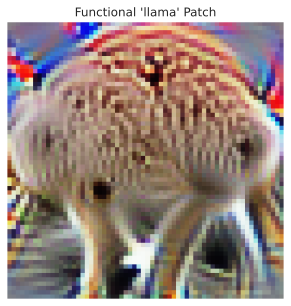

In [10]:
def visualize_patch(patch_tensor):
    patch_0_1 = (torch.tanh(patch_tensor.cpu()) + 1) / 2
    patch_np = patch_0_1.permute(1, 2, 0).numpy()
    patch_np = np.clip(patch_np, a_min=0.0, a_max=1.0)
    return patch_np

adversarial_patch_np = visualize_patch(patch_tensor)

plt.figure(figsize=(5, 5))
plt.imshow(adversarial_patch_np)
plt.title(f"Functional '{target_class_name}' Patch")
plt.axis('off')
plt.show()


final_patch_img = Image.fromarray((adversarial_patch_np * 255).astype(np.uint8))
png_filename = os.path.join(CUSTOM_PATCH_PATH, f"FINAL_{target_class_name}_patch.png")
final_patch_img.save(png_filename)




--- Adversarial Patch (Target: 'llama') ---


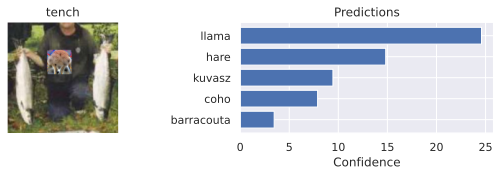

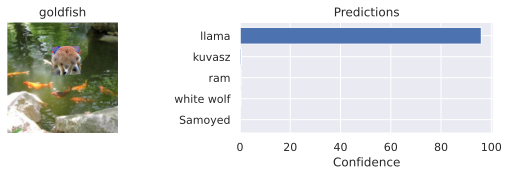

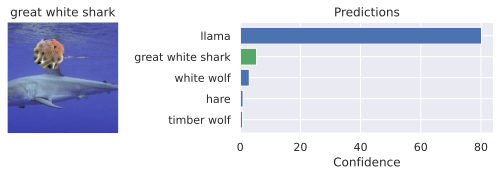

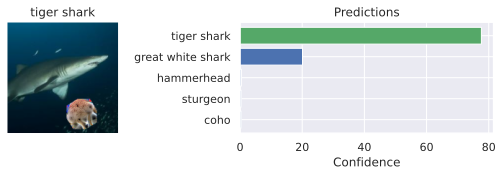

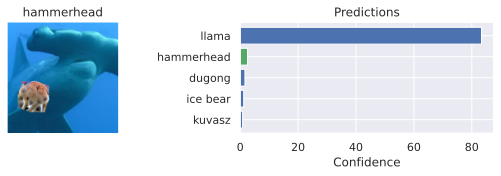

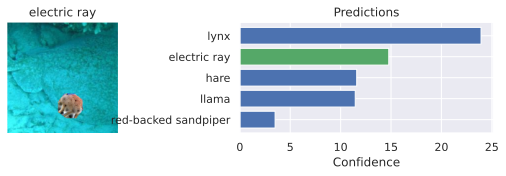

In [11]:
def perform_patch_attack_test(patch_tensor, title):
    print(f"\n--- {title} ---")

    patch_batch = exmp_batch.clone().to(device)
    patch_tensor_device = patch_tensor.to(device)
    patch_batch = place_patch(patch_batch, patch_tensor_device)

    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch) # Already on device

    for i in range(2, 32, 5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

perform_patch_attack_test(patch_tensor, f"Adversarial Patch (Target: '{target_class_name}')")